## Importar librerías

In [1]:
import os
import shutil

import numpy as np
import pandas as pd

from glob import glob
from PIL import Image

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

import tensorflow as tf
from keras import optimizers
from keras.regularizers import l2
from keras.models import Sequential, load_model, Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

%matplotlib inline

from caras_aux import plot_gallery
from sklearn.utils import shuffle
from caras_aux import report_base_error
from sklearn.linear_model import LogisticRegression
from funciones_auxiliares import analisis_roc, plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
from keras.callbacks import ModelCheckpoint
from IPython.display import clear_output
from keras.models import load_model
from keras.metrics import categorical_accuracy
from matplotlib.ticker import MaxNLocator
from numpy.random.mtrand import randint
import tensorflow as tf
from keras import backend as K
import cv2
from keras.metrics import categorical_accuracy
from matplotlib.ticker import MaxNLocator
from numpy.random.mtrand import randint
import tensorflow as tf
from keras import backend as K
import cv2
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.ticker import MaxNLocator


#Funciones 

In [2]:
def preprocess_input(x):
    return x/255.


def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#   #print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["female"]]
    print("Probabilidad clase female : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["male"]]
    print("Probabilidad clase male: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()
    #print(np.shape(imag))
    prob = 100*model.predict(imag)[0][class_indices["female"]]
    print("Probabilidad clase female : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["male"]]
    print("Probabilidad clase male: {:2.1f}%".format(prob))
    print("\n\n")
    return heatmap, superimposed_img

def preprocess_input(x):
      return x/255.
def display_model(model):
     if COLAB:
          display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
     else:
          display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

    
def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                              figsize=(10,4)):
        plt.figure(figsize=figsize)
        ax = plt.subplot(1,2,1)
        plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
        plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
        plt.plot(1+best_i, 100*val_acc[best_i], 'or')
        plt.title('tasa de acierto del modelo (%)', fontsize=18)
        plt.ylabel('tasa de acierto (%)', fontsize=18)
        plt.xlabel('época', fontsize=18)
        plt.legend(['entrenamiento', 'validación'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.subplot(1,2,2)
        plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
        plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
        plt.plot(1+best_i, val_loss[best_i], 'or')
        plt.title('loss del modelo', fontsize=18)
        plt.ylabel('loss', fontsize=18)
        plt.xlabel('época', fontsize=18)
        plt.legend(['entrenamiento', 'validación'], loc='upper left')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show()
    
def loadImages_color(root, factor=1, nimages=False, color=False):
      files = os.listdir(root)
      if not nimages:
          nimages = len(files)
      if not color:
          X = np.zeros((nimages, int(factor*250)*int(factor*250)))
      else:
          X = np.zeros((nimages, 3*int(factor*250)*int(factor*250)))
      for i in range(nimages):
          f = os.path.join(root, files[i])
          if not color:
              img = Image.open(f).convert('L')
          else:
              img = Image.open(f)
          dims = np.shape(img)
          if i==0:
              h = int(factor*dims[0])
              w = int(factor*dims[1])
          img = img.resize((h, w))
          X[i,:] = np.ravel(img)
      return X, h, w, files

# Descarga del datos y preparación 



In [3]:
COLAB = True

In [4]:
!ls -la  

total 28
drwxr-xr-x 1 root root 4096 May 13 10:12 .
drwxr-xr-x 1 root root 4096 May 13 10:09 ..
-rw-r--r-- 1 root root 3247 May 13 10:11 caras_aux.py
drwxr-xr-x 4 root root 4096 May  3 13:41 .config
-rw-r--r-- 1 root root 3237 May 13 10:11 funciones_auxiliares.py
drwxr-xr-x 2 root root 4096 May 13 10:12 __pycache__
drwxr-xr-x 1 root root 4096 May  3 13:42 sample_data


In [5]:
if COLAB:
    id_ = "1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei"
    aux = "'https://docs.google.com/uc?export=download&id={}&confirm=t'".format(id_)
    !wget $aux -O ./gender.zip
    !unzip ./gender.zip
    #PONER A

--2022-05-13 10:12:15--  https://docs.google.com/uc?export=download&id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&confirm=t
Resolving docs.google.com (docs.google.com)... 66.102.1.101, 66.102.1.138, 66.102.1.113, ...
Connecting to docs.google.com (docs.google.com)|66.102.1.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2lmrcp1nck9pmd47pea3e3pbl7b2reg0/1652436675000/03894129457800149408/*/1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei?e=download [following]
--2022-05-13 10:12:15--  https://doc-0s-0c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2lmrcp1nck9pmd47pea3e3pbl7b2reg0/1652436675000/03894129457800149408/*/1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei?e=download
Resolving doc-0s-0c-docs.googleusercontent.com (doc-0s-0c-docs.googleusercontent.com)... 173.194.76.132, 2a00:1450:400c:c00::84
Connecting to doc-0s-0c-docs.googleusercontent.com (doc-0s-0c-docs.go

In [6]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1jifedd49sgZI2ZA6722h9R-mRh2Ciqzp',
                                        dest_path='./caras_aux.py.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1w6rSNy0mDds1cDNBtbL9U1bkF4PiGCnK',
                                        dest_path='./funciones_auxiliares.py.zip', unzip=True)

Unzipping...Done.
Unzipping...Done.


In [7]:
# Colocamos las fotos en carpetas

#train - fotos de entrenamiento
#test -  fotos de test
#valid -  fotos de validación

!mkdir '/content/gender/train'
!mkdir '/content/gender/test'
!mkdir '/content/gender/valid'

!mkdir '/content/gender/train/male'
!mkdir '/content/gender/test/male'
!mkdir '/content/gender/valid/male'

!mkdir '/content/gender/train/female'
!mkdir '/content/gender/test/female'
!mkdir '/content/gender/valid/female'

#Rutas de las carpeta

#male
train_data_male = '/content/gender/train/male'
test_data_male = '/content/gender/test/male'
valid_data_male = '/content/gender/valid/male'

#female
train_data_female = '/content/gender/train/female'
test_data_female = '/content/gender/test/female'
valid_data_female = '/content/gender/valid/female'

#guardamos los nombres de cada fotos en las siguientes varibles.

fotos_females = sorted(glob("/content/gender/female/*.jpg"))
fotos_males = sorted(glob("/content/gender/male/*.jpg"))

fotos=fotos_females+fotos_males

len(fotos),len(fotos_females),len(fotos_males)

(2153, 1070, 1083)

female


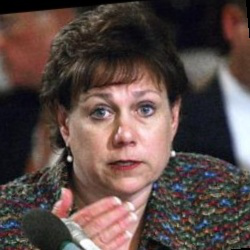

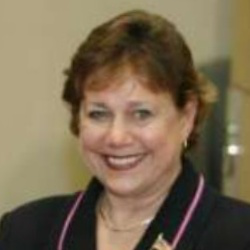

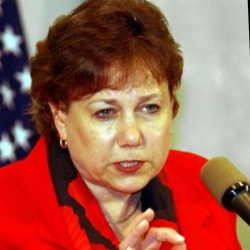

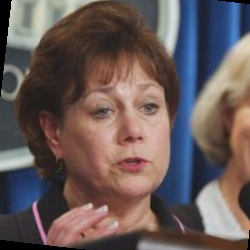

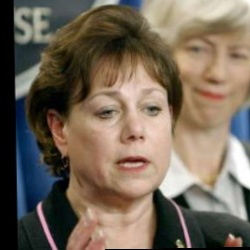

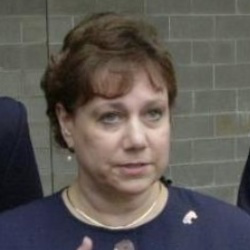

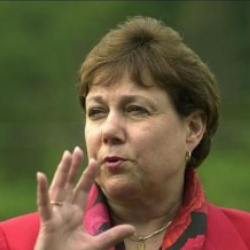

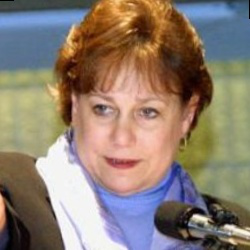

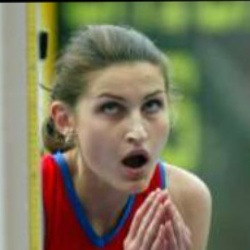

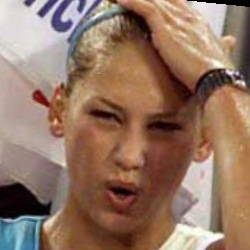


male


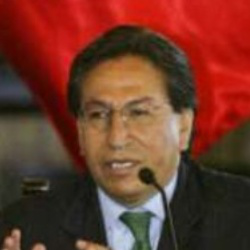

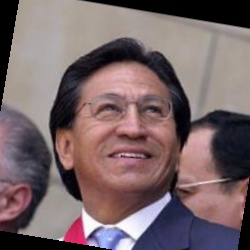

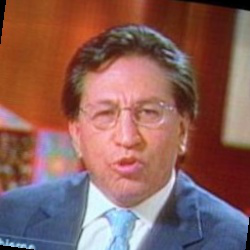

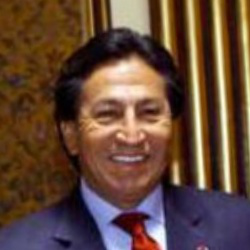

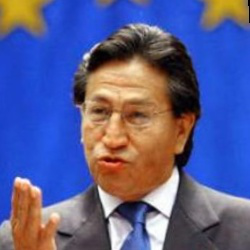

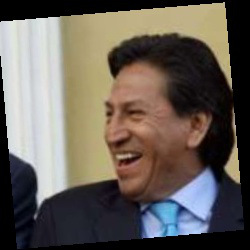

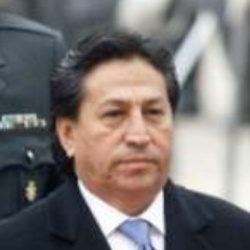

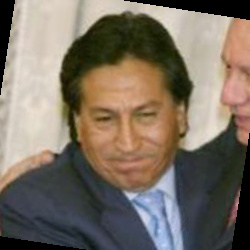

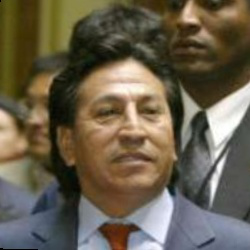

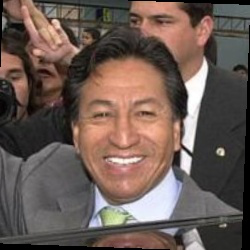

In [8]:
#creamos  las etiquetas  de los datos
etiquetas=len(fotos_females)*[1] + len(fotos_males)*[0]

#creamos las particiones 
x_train, x_test, y_train, y_test = train_test_split(fotos,etiquetas, test_size=0.3,random_state=1997,stratify=etiquetas)
x_tr, x_valid, y_tr, y_valid = train_test_split(x_train,y_train,test_size=0.2,random_state=1997)

#Enviamos los datos a su directorio final 

for g in x_tr:
    if g.split(sep='/')[3]=='male':
      shutil.move(g, train_data_male)
    if g.split(sep='/')[3]=='female':
      shutil.move(g, train_data_female)

for g in x_test:
    if g.split(sep='/')[3]=='male':
      shutil.move(g, test_data_male)
    if g.split(sep='/')[3]=='female':
      shutil.move(g, test_data_female)

for g in x_valid:
    if g.split(sep='/')[3]=='male':
      shutil.move(g, valid_data_male)
    if g.split(sep='/')[3]=='female':
      shutil.move(g, valid_data_female)

#Borramos lo que sobra 
!rmdir '/content/gender/female'
!rmdir '/content/gender/male'

#comprobamos female 
print("female")
fotos = sorted(glob("/content/gender/train/female/*.jpg"))
for foto in fotos[100:110]:
    fotografia = load_img(foto)
    display(fotografia)
    print()

#comprobamos male 
print("male")
fotos = sorted(glob("/content/gender/train/male/*.jpg"))
for foto in fotos[130:140]:
    fotografia = load_img(foto)
    display(fotografia)
    print()

In [9]:
# cargo las imágenes y preparo los datos

train_male=len(glob(train_data_male+'/*.jpg'))
valid_male=len(glob(valid_data_male+'/*.jpg'))
test_male=len(glob(test_data_male +'/*.jpg'))

train_female=len(glob(train_data_female+'/*.jpg'))
valid_female=len(glob(valid_data_female+'/*.jpg'))
test_female=len(glob(test_data_female +'/*.jpg'))

factor = 0.15 # factor de reducción de resolución de las imágenes, debe ser  # >0 y <=1 (en cuyo caso la resolución es la original, 250x250)

x_train_0, height, width, files_train_0 = loadImages_color(train_data_male,factor=factor, nimages=train_male,color=True)
x_train_1, height, width, files_train_1 = loadImages_color(train_data_female,factor=factor, nimages=train_female,color=True)

x_test_0, height, width, files_test_0 = loadImages_color(test_data_male, factor=factor, nimages=test_male,color=True)
x_test_1, height, width, files_test_1 = loadImages_color(test_data_female, factor=factor, nimages=test_female,color=True)

x_valid_0, height, width, files_valid_0 = loadImages_color(valid_data_male,factor=factor, nimages=valid_male, color=True)
x_valid_1, height, width, files_valid_1 = loadImages_color(valid_data_female,factor=factor, nimages=valid_female,color=True)

# juntamos todo x
x_train=np.concatenate((x_train_0,x_train_1), axis=0)
x_test=np.concatenate((x_test_0,x_test_1),axis=0)
x_valid=np.concatenate((x_valid_0,x_valid_1),axis=0)
# juntamos todo y
y_train=np.array(x_train_0.shape[0]*[0]+x_train_1.shape[0]*[1])
y_test=np.array(x_test_0.shape[0]*[0]+x_test_1.shape[0]*[1])
y_valid=np.array(x_valid_0.shape[0]*[0]+x_valid_1.shape[0]*[1])
#barajamos
x_tr_b, y_tr_b = shuffle(x_train, y_train)
x_te_b, y_te_b = shuffle(x_test, y_test)
x_va_b, y_va_b = shuffle(x_valid, y_valid)

\Estadísticas básicas de la base de datos :
  # clases: 2
  # patrones: 2153
  # caracteristicas: 4107

Algunas imágenes del dataset de train:


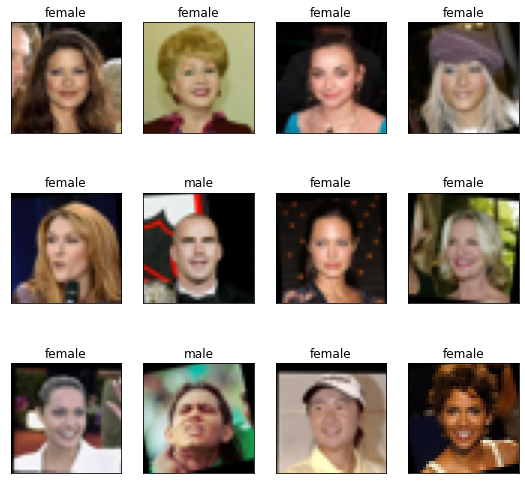


Algunas imágenes del dataset de test:


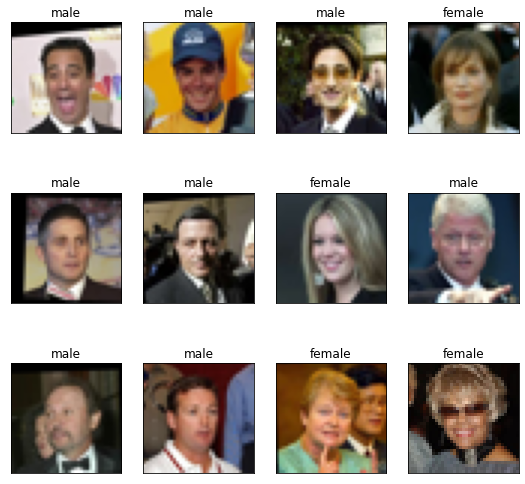

In [10]:
target_names = np.array(['female', 'male'])
num_clases = len(target_names)
N0 = train_male+test_male+valid_male
N1 = train_female+test_female+valid_female
y = N0*[0] + N1*[1]
y = np.array(y)
patrones=N0+N1
num_caracteristicas=x_tr_b[1].shape
cmap = None
x_aux0 = x_tr_b[:12].reshape((12, height, width, 3)).astype(int)
x_aux1 = x_te_b[:12].reshape((12, height, width, 3)).astype(int)
print('\Estadísticas básicas de la base de datos :')
print('  # clases: %d' % num_clases)
print('  # patrones: %d' % patrones)
print('  # caracteristicas: %d' % num_caracteristicas)
print('\nAlgunas imágenes del dataset de train:')
plot_gallery(x_aux0, ['female' if item==1 else 'male' for item in y_tr_b[:12]], cmap=cmap)
print('\nAlgunas imágenes del dataset de test:')
plot_gallery(x_aux1,['female' if item==1 else 'male' for item in y_te_b[:12]], cmap=cmap);

In [11]:
# Normalización de datos
x_tr_b /= 255 #  equivalente a: X = X / 255
x_te_b /= 255
x_va_b /= 255
print('train:',x_tr_b.min(), x_tr_b.max())
print('test:',x_te_b.min(), x_te_b.max())
print('valid:',x_va_b.min(), x_va_b.max())

train: 0.0 1.0
test: 0.0 1.0
valid: 0.0 1.0


Ahora seguimos entendiendo la estructura de los datos:

In [12]:
y_tr_b.shape

(1205,)

In [13]:
np.unique(y_tr_b)

array([0, 1])

In [14]:
x_tr_b.shape

(1205, 4107)

In [15]:
x_tr_b.shape[1] / 3 # ahora por cada píxel tenemos 3 valores: R, G, B (la imagen es a color)

1369.0

In [16]:
np.sqrt(x_tr_b.shape[1] / 3) # lado de la imagen

37.0

# Separación training-test

In [17]:
#Chequeo de las dimensiones de estos conjuntos:
print(x_tr_b.shape, y_tr_b.shape)
print(x_va_b.shape, y_va_b.shape) 
print(x_te_b.shape, y_te_b.shape)

(1205, 4107) (1205,)
(302, 4107) (302,)
(646, 4107) (646,)


In [18]:
#todo bien dado que estas dimesiones coinciden 
#x_tr_b = y_tr_b
#x_va_b = y_va_b 
#x_te_b = y_te_b


# **Estadísticas de las clases**

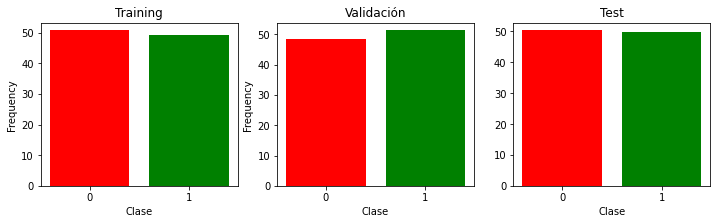

- Priori de la clase 0 en training: 0.507
- Priori de la clase 1 en training: 0.493
- Clase mayoritaria en training: 0

- Priori de la clase 0 en test: 0.503
- Priori de la clase 1 en test: 0.497
- Score de la clasificacion por mayoria en test: 0.503


In [19]:
plt.figure(figsize=(12,3))
ax = plt.subplot(1,3,1)
clases, counts = np.unique(y_tr_b, return_counts=True)
plt.bar(clases, 100*counts/len(y_tr_b), color=["red", "green"])
plt.title('Training'); plt.xlabel('Clase'); plt.ylabel('Frequency'); ax.set_xticks(clases)
ax = plt.subplot(1,3,2)
clases, counts = np.unique(y_va_b, return_counts=True)
plt.bar(clases, 100*counts/len(y_va_b), color=["red", "green"])
plt.title('Validación'); plt.xlabel('Clase'); plt.ylabel('Frequency '); ax.set_xticks(clases)
ax = plt.subplot(1,3,3)
none, counts = np.unique(y_te_b, return_counts=True)
plt.bar(clases, 100*counts/len(y_te_b), color=["red", "green"])
plt.title('Test'); plt.xlabel('Clase'); ax.set_xticks(clases); plt.show()
report_base_error(x_tr_b, y_tr_b, x_te_b, y_te_b)

# **Modelo de referencia**

In [20]:
# Regresión logística:

model0 = LogisticRegression(max_iter=1000, C=0.1) # C: factor de regularización. Cuanto más bajo, más "poda" (al revés que en Keras)
model0.fit(x_tr_b, y_tr_b)

LogisticRegression(C=0.1, max_iter=1000)

Scores en training, validación y test:

In [21]:
model0.score(x_tr_b, y_tr_b), model0.score(x_va_b, y_va_b), model0.score(x_te_b, y_te_b)

(0.9493775933609958, 0.8112582781456954, 0.8065015479876161)

In [22]:
probs_test = model0.predict_proba(x_te_b)
probs_test[:5]

array([[0.92842659, 0.07157341],
       [0.47303004, 0.52696996],
       [0.38701245, 0.61298755],
       [0.00266806, 0.99733194],
       [0.95665764, 0.04334236]])

In [23]:
probs_test_male = probs_test[:,1] # segunda columna

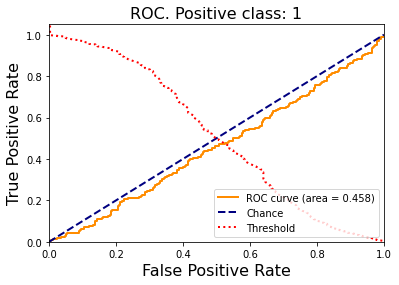

In [24]:
analisis_roc(y=y_test, positive_class_scores=probs_test_male, POSITIVE_CLASS=1)

In [25]:
# clases predichas en test:
predicciones_test = model0.predict(x_te_b)
predicciones_test[:5]

array([0, 1, 1, 1, 0])

Confusion matrix, without normalization
[[164 161]
 [174 147]]


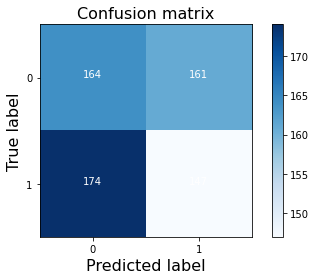

In [26]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)

# Implementación en Keras de un modelo

In [27]:
x_tr_b.shape

(1205, 4107)

In [28]:
lado = int(np.sqrt(x_tr_b.shape[1] / 3))
lado

37

In [29]:
x_tr_2D   = x_tr_b.reshape((len(x_tr_b),lado,lado,3))
x_va_2D  = x_va_b.reshape((len(x_va_b),lado,lado,3))
x_te_2D = x_te_b.reshape((len(x_te_b),lado,lado,3))

x_tr_2D.shape, x_te_2D.shape , x_va_2D.shape

((1205, 37, 37, 3), (646, 37, 37, 3), (302, 37, 37, 3))

In [30]:
input_dims = x_tr_2D.shape[1:]
input_dims

(37, 37, 3)

In [31]:
model1 = Sequential()

model1.add(Conv2D(filters=4, input_shape=input_dims, 
          kernel_size=(5,5), activation='relu'))
model1.add(MaxPooling2D())
model1.add(Conv2D(filters=10, kernel_size=(5,5), activation='relu'))
model1.add(MaxPooling2D())

# Fase de clasificación:
model1.add(Flatten())
model1.add(Dropout(rate=0.3)) 
model1.add(Dense(10, activation='relu', kernel_regularizer=l2(0.1)))
model1.add(Dense(1, activation='sigmoid'))       # problema de clasificación en 2 clases: 0 female, 1 male

#compilamos
model1.compile(loss='binary_crossentropy', optimizer=Adam(0.0001),metrics=["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 33, 4)         304       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 10)        1010      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 360)               0         
                                                                 
 dropout (Dropout)           (None, 360)               0

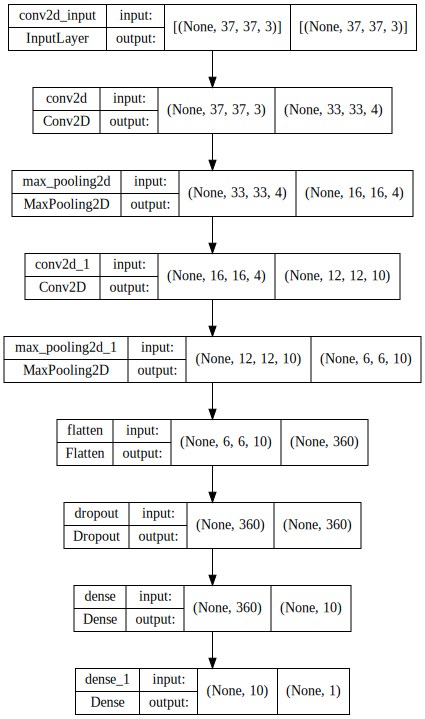

In [32]:
display_model(model1)

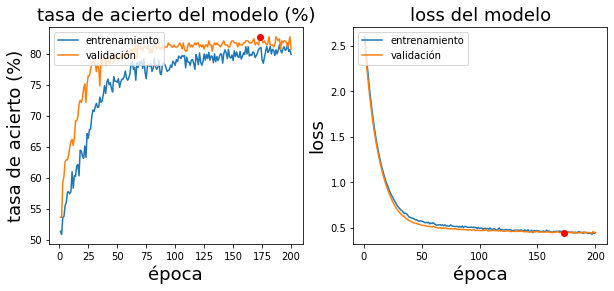

In [33]:
#entrenamos el modelo

acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []
epochs = 200
modelpath="best_model.h5"
checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

for e in range(epochs):
    history = model1.fit(x_tr_2D, y_tr_b, epochs=1, batch_size=32, callbacks=callbacks_list,verbose=10, validation_data=(x_va_2D,y_va_b))
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from", best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)
model1 = load_model(modelpath)

Score en training:  0.8157676348547718
Score en test:  0.7879256965944272
Score en validacion:  0.8278145695364238
Confusion matrix, without normalization
[[250  75]
 [ 62 259]]


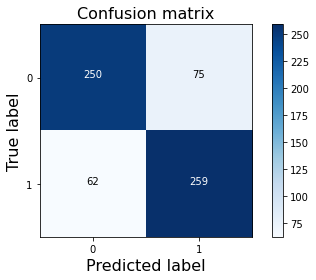

In [34]:
#Score en training:
print("Score en training: ",np.mean(y_tr_b == np.round(model1.predict(x_tr_2D).flatten())))
#Score en test:
probs_predicciones_test = model1.predict(x_te_2D).flatten()
predicciones_test = np.round(probs_predicciones_test)
print("Score en test: ",np.mean(y_te_b == predicciones_test))
#Score en validacion:
print("Score en validacion: ",np.mean(y_va_b == np.round(model1.predict(x_va_2D).flatten())))
plot_confusion_matrix(y=y_te_b, y_pred=predicciones_test)

# Optimizamos la red

In [35]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 170, 170
normed_dims = (img_height, img_width)

In [36]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu',input_shape=normed_dims+(3,)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(32, activation='relu',))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

#compilamos
model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001),metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 168, 168, 32)      896       
                                                                 
 conv2d_3 (Conv2D)           (None, 166, 166, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 83, 83, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 83, 83, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 81, 81, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                  

In [37]:
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function = preprocess_input,rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest', 
                                   shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(dtype='float32',preprocessing_function = preprocess_input)

train_data_dir = '/content/gender/train'
validation_data_dir = '/content/gender/valid'
test_data_dir = '/content/gender/test'

In [39]:
#para mejorar los valores de la red, vamos a aumentar el numero de imagenes que usamos con data augmentation:

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=20,      # rotación máxima (20 grados)
    width_shift_range=0.1,  # traslación horizontal (10% máximo)
    height_shift_range=0.1, # traslación vertical (10% máximo)
    #fill_mode='nearest',
    #fill_mode='reflect',
    fill_mode='constant',
    shear_range=0.1,        # factor de deformación máximo
    zoom_range=0.2,         # factor de zoom máximo
    horizontal_flip=True    # espejo horizontal)

In [40]:
imagen_num = np.expand_dims(np.array(fotografia), axis=0)

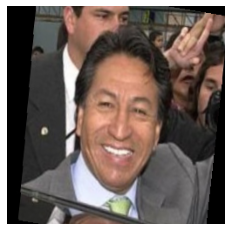

In [41]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

In [42]:
batch_size=32
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size=normed_dims,
    batch_size=batch_size,shuffle=True,class_mode='categorical') # binary, categorical, sparse

validation_generator = val_datagen.flow_from_directory(validation_data_dir,target_size=normed_dims,batch_size=batch_size,
                                                       shuffle=False,class_mode='categorical') # binary, categorical, sparse

test_generator = test_datagen.flow_from_directory(test_data_dir,target_size=normed_dims,batch_size=batch_size,
    shuffle=False,class_mode='categorical') # binary, categorical, sparse

Found 1205 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
Found 646 images belonging to 2 classes.


In [43]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [44]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n
number_train_samples, number_val_samples, number_test_samples

(1205, 302, 646)

In [45]:
epochs = 100
num_train_steps=(number_train_samples // batch_size)*epochs
lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=0.001,
                               end_learning_rate=1e-5,
                               decay_steps=num_train_steps)

In [46]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=lr_scheduler),
            #  optimizer=optimizers.RMSprop(lr=1e-4),
              # optimizer=optimizers.rmsprop_v2.RMSprop(),
              metrics=[categorical_accuracy])

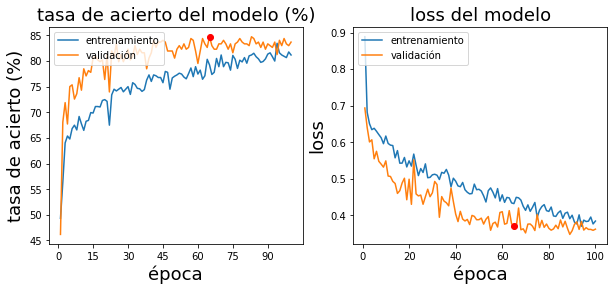

In [47]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []
modelpath="model_current_best_parte2.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_categorical_accuracy', verbose=1,save_best_only=True,mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit(train_generator,  
                        steps_per_epoch=number_train_samples // batch_size,
                        epochs=1,
                        callbacks=callbacks_list,
                        verbose=1,
                        shuffle = False,
                        validation_data=validation_generator,
                        validation_steps=number_val_samples // batch_size)
    
    if history.history['val_categorical_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_categorical_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_categorical_accuracy'][-1]
    
    acum_tr_acc.append(history.history['categorical_accuracy'][0])
    acum_val_acc.append(history.history['val_categorical_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [48]:
 history.history

{'categorical_accuracy': [0.8116554021835327],
 'loss': [0.38425174355506897],
 'val_categorical_accuracy': [0.8368055820465088],
 'val_loss': [0.36210736632347107]}

In [49]:
scores_tr = model.evaluate(train_generator)
print('Train accuracy:', scores_tr[1])
print()

scores_va = model.evaluate(validation_generator)
print('Valid accuracy:', scores_va[1])
print()

scores_te = model.evaluate(test_generator)
print('Test accuracy :', scores_te[1])

38/38 [==============================] - 11s 278ms/step - loss: 0.3269 - categorical_accuracy: 0.8515
Train accuracy: 0.8514522910118103

10/10 [==============================] - 1s 126ms/step - loss: 0.3711 - categorical_accuracy: 0.8344
Valid accuracy: 0.8344370722770691

21/21 [==============================] - 2s 87ms/step - loss: 0.3761 - categorical_accuracy: 0.8406
Test accuracy : 0.8405572772026062


In [50]:
model = load_model(modelpath)

In [51]:
y_real = test_generator.classes
y_pred_proba = model.predict(test_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
print('')
print(classification_report(y_real, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.85      0.84       321
           1       0.85      0.82      0.84       325

    accuracy                           0.84       646
   macro avg       0.84      0.84      0.84       646
weighted avg       0.84      0.84      0.84       646



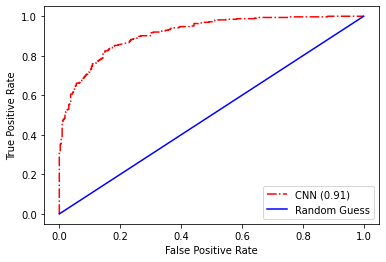

In [52]:
clase_positiva = 1
fpr, tpr, thresholds = roc_curve(y_real==clase_positiva, y_pred_proba[:,clase_positiva])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

In [53]:
test_datagen2 = ImageDataGenerator(dtype='float32',preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(test_data_dir,target_size=normed_dims,batch_size=test_generator.n, # todas las imágenes del directorio test
    shuffle=False,class_mode='categorical')

Found 646 images belonging to 2 classes.


In [54]:
test_generator2.reset()
x_te, y_te = test_generator2.next()
x_te.shape

(646, 170, 170, 3)

In [55]:
class_indices = test_generator2.class_indices
class_indices

{'female': 0, 'male': 1}

Probabilidad male: 20.1%
Probabilidad female : 79.9%


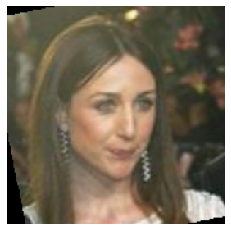

In [56]:
ind_te1 = randint(1,646) # 1500
image = x_te[ind_te1].copy()
fig=plt.imshow(image, cmap='jet')
plt.axis("off");
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["male"]]
print("Probabilidad male: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["female"]]
print("Probabilidad female : {:2.1f}%".format(100*p))

Probabilidad male: 48.8%
Probabilidad female : 51.2%


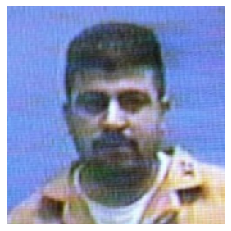

In [57]:
ind_te1 = randint(1,646) # 1500
image = x_te[ind_te1].copy()
fig=plt.imshow(image, cmap='jet')
plt.axis("off");
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["male"]]
print("Probabilidad male: {:2.1f}%".format(100*p))
p = model.predict(np.expand_dims(image, axis=0))[0][class_indices["female"]]
print("Probabilidad female : {:2.1f}%".format(100*p))

In [58]:
###########################                    heatmaps       ##############################################

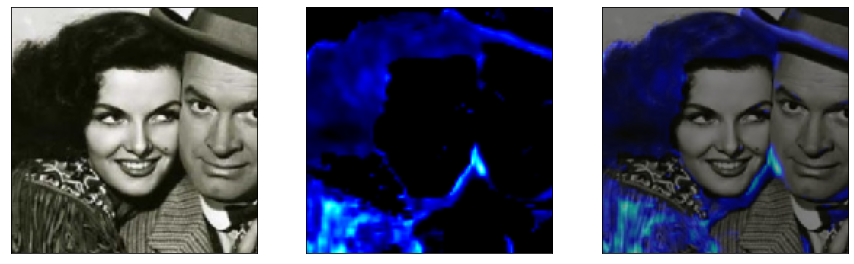

Probabilidad clase female : 66.0%
Probabilidad clase male: 34.0%





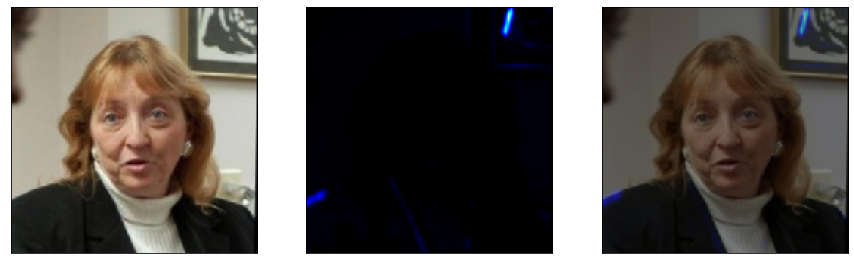

Probabilidad clase female : 1.5%
Probabilidad clase male: 98.5%





In [59]:
#sacomos algunos heatmaps  
indice = 316 
for i in range(indice, indice+2):
    show_heatmap(model, x_te[i])

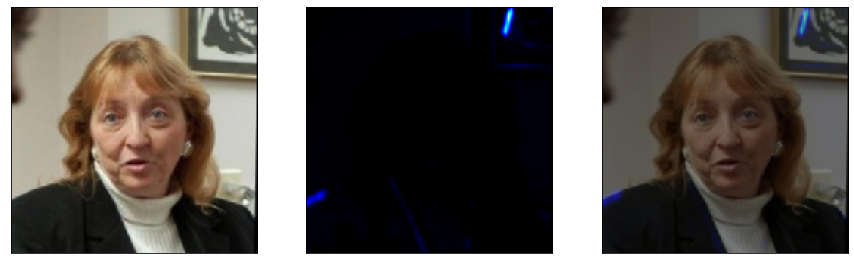

Probabilidad clase female : 1.5%
Probabilidad clase male: 98.5%





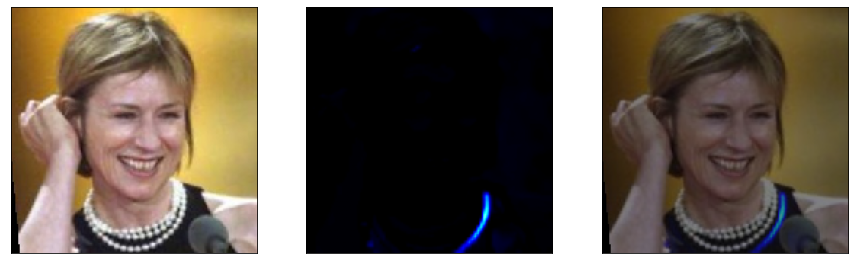

Probabilidad clase female : 2.3%
Probabilidad clase male: 97.7%





In [60]:
# mujeres que clasifico como mujeres hombres

inds = np.where(y_te[:,class_indices["female"]]==1)[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i,class_indices["female"]])
for i in inds[:2]:
    show_heatmap(model, x_te[i])


    #parece que  si que exiten sesgos, el algoritmo tiene problemas para detectar el genero en mujeres de mediana edad y o envejecidas dado que las clasifica como hombres   

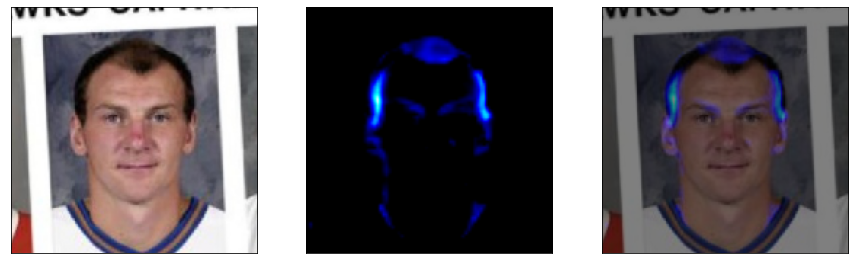

Probabilidad clase female : 96.6%
Probabilidad clase male: 3.4%





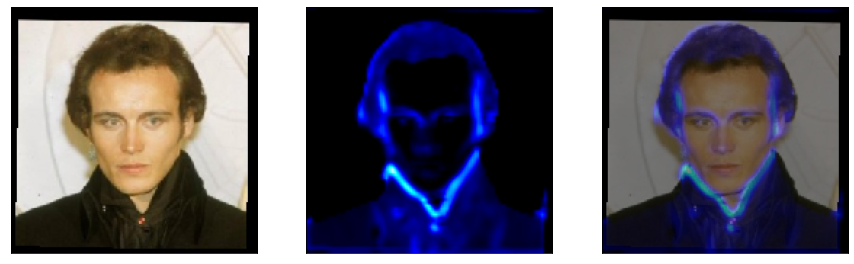

Probabilidad clase female : 92.4%
Probabilidad clase male: 7.6%





In [61]:
#hombres que clasifico como mujeres

inds = np.where(y_te[:,class_indices["male"]]==1)[0]
inds = sorted(inds, key=lambda i:y_pred_proba[i,class_indices["male"]])
for i in inds[:2]:
    show_heatmap(model, x_te[i])
